In [1]:
import sys
sys.path.append('..')
from MPRA_exp.utils import *
from MPRA_exp.metrics import *

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor, MLPClassifier

In [2]:
main_df = pd.read_csv('data/Sei_Siraj_features.csv')
main_df

/tmp/ipykernel_2040153/2479411455.py:1: DtypeWarning: Columns (6,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv('data/Sei_Siraj_features.csv')


,seq,A549,HepG2,K562,SKNSH,HCT116,is_ref,chr,pos,ref,...,A549_H3K36me3_pred_logit,A549_CTCF_pred_logit,HCT116_DNase_pred_logit,HCT116_H3K4me1_pred_logit,HCT116_H3K4me3_pred_logit,HCT116_H3K9me3_pred_logit,HCT116_H3K27me3_pred_logit,HCT116_H3K27ac_pred_logit,HCT116_H3K36me3_pred_logit,HCT116_CTCF_pred_logit
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.667516,-0.704147,0.538641,0.159069,True,chr1,14677.0,G,...,-8.451625,-5.178783,-4.183375,-5.327607,-4.361067,-5.354374,-5.090679,-5.481699,-7.614980,-5.942789
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.415984,0.554099,0.441904,-0.288019,False,chr1,14677.0,G,...,-8.504293,-5.139558,-4.202863,-5.392529,-4.404792,-5.399591,-5.143095,-5.516986,-7.654972,-5.899889
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,1.269937,-0.391222,0.752052,1.100437,True,chr1,63697.0,T,...,-9.174150,-7.003038,-4.215008,-6.039615,-6.419853,-5.848139,-5.366335,-6.907754,-8.509213,-7.614042
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,1.151995,-0.659023,0.204721,1.050619,False,chr1,63697.0,T,...,-9.129220,-7.052451,-4.185768,-6.067505,-6.605231,-5.841283,-5.615144,-7.049058,-8.459022,-7.640062
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,NaN,-0.211076,-0.007174,0.499376,0.257572,True,chr1,64764.0,C,...,-10.511040,-9.144752,-7.840627,-9.348326,-8.855122,-5.563872,-5.998085,-9.020669,-10.423471,-9.197061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661768,CTCGGAGTTCAAGAAAATCATCTCACACGGCCGTCTCAGACCCTTC...,NaN,0.591628,-0.315267,0.068697,NaN,NaN,chr0,NaN,NaN,...,-9.531923,-7.365154,-5.673260,-7.488030,-7.468271,-5.463563,-5.782350,-8.238791,-8.204515,-8.370657
661769,GCAATCCTACCCAGACAGATGCAGACAGCGACCTGGTGGGGGATGT...,NaN,-0.359782,-0.134821,-0.022281,NaN,NaN,chr0,NaN,NaN,...,-10.153594,-4.437609,-5.104057,-7.885853,-8.155043,-5.962064,-5.873489,-9.224743,-8.610517,-5.241802
661770,CCTATGCTGCCTCCTATGCCCTTGTCATCATTGCCATTTTTGAGCT...,NaN,0.489900,0.646673,0.462366,NaN,NaN,chr0,NaN,NaN,...,-9.759465,-5.842908,-6.005930,-8.433203,-8.275389,-5.273757,-6.243771,-8.621416,-8.746486,-6.197965
661771,AGCCACAACAAAACAGCCAGTTAATGTGGAAACAAGGTCGACAACT...,NaN,-0.014411,-0.061676,0.239693,NaN,NaN,chr0,NaN,NaN,...,-9.687290,-7.883479,-5.405044,-7.628364,-7.324626,-5.501766,-5.198348,-7.477599,-8.630016,-8.418754


In [3]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(main_df), dtype=bool)
data_split_dict['chrom'] = main_df['chr'].isin([f'chr{i}' for i in range(1, 23)])
data_split_dict['train'] = main_df['chr'].isin([f'chr{i}' for i in range(3, 23)])
data_split_dict['valid'] = main_df['chr'].isin(['chr1'])
data_split_dict['test'] = main_df['chr'].isin(['chr2'])
data_split_dict['designed'] = main_df['chr'].isin(['chr0'])


cell_types = ['HepG2', 'K562', 'A549', 'HCT116']
main_df['diff_exp'] = (main_df[cell_types].max(axis=1) - main_df[cell_types].min(axis=1)) > 1
data_split_dict['const'] = ~main_df['diff_exp']
data_split_dict['diff']  = main_df['diff_exp']

In [4]:
# cell_types = ['HepG2', 'K562', 'A549', 'HCT116']
# assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'CTCF']
# data_splits = ['total', 'const', 'diff']

# for assay in assays:
#     r_matrix = np.zeros((len(cell_types), len(data_splits)))
#     r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits)
#     for cell_type in cell_types:
#         for data_split in data_splits:
#                 condition = data_split_dict[data_split]
#                 x = main_df[condition][f'{cell_type}_{assay}_pred_logit']
#                 y = main_df[condition][cell_type]
#                 r = pearson(x, y)
#                 r_matrix.loc[cell_type, data_split] = r
#                 # print(f'{cell_type} {assay} {data_split} {data_split_2} pearson r = {r:.3f}')
#                 # r = spearman(x, y)
#                 # print(f'{cell_type} {assay} {data_split} total spearman r = {r:.3f}')
#     print(assay)
#     print(r_matrix)




# cell_types = ['HepG2', 'K562', 'A549', 'HCT116']
# assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'CTCF']
# data_splits = ['train', 'valid', 'test', 'designed']

# for assay in assays:
#     r_matrix = np.zeros((len(cell_types), len(data_splits)))
#     r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits)
#     for cell_type in cell_types:
#         for data_split in data_splits:
#                 condition = data_split_dict[data_split]
#                 x = main_df[condition][f'{cell_type}_{assay}_pred_logit']
#                 y = main_df[condition][cell_type]
#                 r = pearson(x, y)
#                 r_matrix.loc[cell_type, data_split] = r
#                 # print(f'{cell_type} {assay} {data_split} {data_split_2} pearson r = {r:.3f}')
#                 # r = spearman(x, y)
#                 # print(f'{cell_type} {assay} {data_split} total spearman r = {r:.3f}')
#     print(assay)
#     print(r_matrix)

In [6]:
cell_types = ['HepG2', 'K562', 'A549', 'HCT116']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'CTCF']
data_splits = ['chrom']
data_splits_2 = ['total', 'const', 'diff']
data_splits_combined = [f'{a}_{b}' for a in data_splits for b in data_splits_2]

for assay in assays:
    r_matrix = np.zeros((len(cell_types), len(data_splits_combined)))
    r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits_combined)
    for cell_type in cell_types:
        for data_split in data_splits:
            for data_split_2 in data_splits_2:
                condition = data_split_dict[data_split] & data_split_dict[data_split_2]
                x = main_df[condition][f'{cell_type}_{assay}_pred_logit']
                y = main_df[condition][cell_type]
                r = pearson(x, y)
                r_matrix.loc[cell_type, f'{data_split}_{data_split_2}'] = r
                # print(f'{cell_type} {assay} {data_split} {data_split_2} pearson r = {r:.3f}')
                # r = spearman(x, y)
                # print(f'{cell_type} {assay} {data_split} total spearman r = {r:.3f}')
    print(assay)
    print(r_matrix)


data_splits = ['train', 'valid', 'test', 'designed']
data_splits_2 = ['total']
data_splits_combined = [f'{a}_{b}' for a in data_splits for b in data_splits_2]

for assay in assays:
    r_matrix = np.zeros((len(cell_types), len(data_splits_combined)))
    r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits_combined)
    for cell_type in cell_types:
        for data_split in data_splits:
            for data_split_2 in data_splits_2:
                condition = data_split_dict[data_split] & data_split_dict[data_split_2]
                x = main_df[condition][f'{cell_type}_{assay}_pred_logit']
                y = main_df[condition][cell_type]
                r = pearson(x, y)
                r_matrix.loc[cell_type, f'{data_split}_{data_split_2}'] = r
                # print(f'{cell_type} {assay} {data_split} {data_split_2} pearson r = {r:.3f}')
                # r = spearman(x, y)
                # print(f'{cell_type} {assay} {data_split} total spearman r = {r:.3f}')
    print(assay)
    print(r_matrix)

DNase
        chrom_total  chrom_const  chrom_diff
HepG2      0.444330     0.309237    0.482808
K562       0.498502     0.351913    0.504837
A549       0.342703     0.194984    0.360094
HCT116     0.423549     0.266958    0.521724
H3K4me1
        chrom_total  chrom_const  chrom_diff
HepG2      0.350905     0.233341    0.373917
K562       0.391118     0.271285    0.361035
A549       0.302663     0.207573    0.258434
HCT116     0.395851     0.259191    0.484048
H3K4me3
        chrom_total  chrom_const  chrom_diff
HepG2      0.465868     0.345707    0.516129
K562       0.449417     0.318128    0.462550
A549       0.360124     0.223366    0.375359
HCT116     0.441356     0.304945    0.536472
H3K9me3
        chrom_total  chrom_const  chrom_diff
HepG2      0.015402    -0.032098    0.030299
K562       0.285132     0.184419    0.284456
A549       0.232632     0.088920    0.302725
HCT116    -0.055610    -0.084550    0.057788
H3K27me3
        chrom_total  chrom_const  chrom_diff
HepG2      0.254

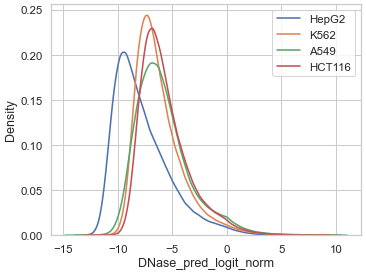

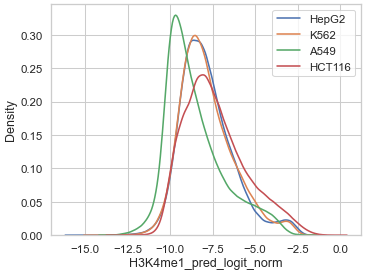

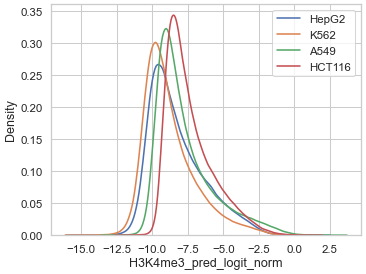

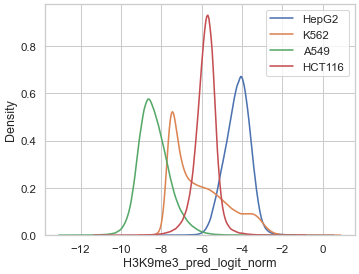

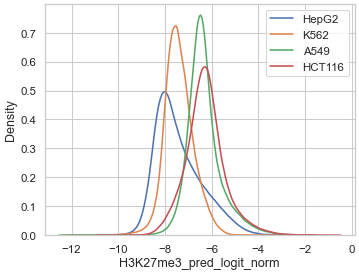

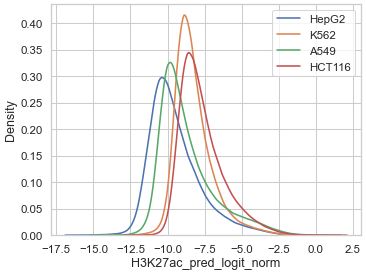

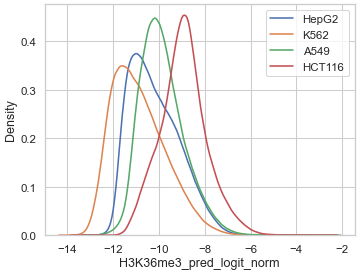

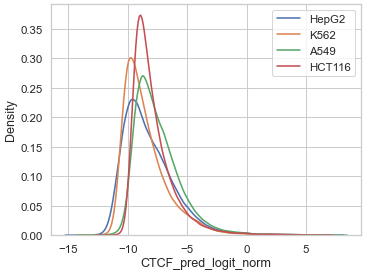

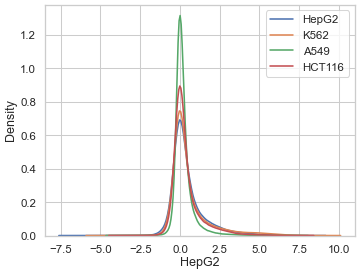

In [28]:
for assay in assays:
    plt.figure(figsize=(8, 6), dpi=50)
    for cell_type in cell_types:
        x = main_df[f'{cell_type}_{assay}_pred_logit']
        sns.kdeplot(x, label=cell_type)
        plt.xlabel(f'{assay}_pred_logit_norm')
    plt.legend()


plt.figure(figsize=(8, 6), dpi=50)
for cell_type in cell_types:
        y = main_df[cell_type]
        sns.kdeplot(y, label=cell_type)
plt.legend()

In [7]:
# normalize to mean = 0
for assay in assays:
    for cell_type in cell_types:
        x = main_df[f'{cell_type}_{assay}_pred_logit']
        x_mean = np.mean(x)
        x_std = 1  # np.std(x)
        x = (x - x_mean) / x_std
        main_df[f'{cell_type}_{assay}_pred_logit_norm'] = x

# for cell_type in cell_types:
#     data_split = 'train'
#     selected_index = (main_df['chr'].isin(data_split_dict[data_split]))
#     y = main_df[selected_index][f'{cell_type}']
#     y_mean = 0
#     y_std = np.std(y)
#     main_df[f'{cell_type}_norm'] = (main_df[f'{cell_type}'] - y_mean) / y_std

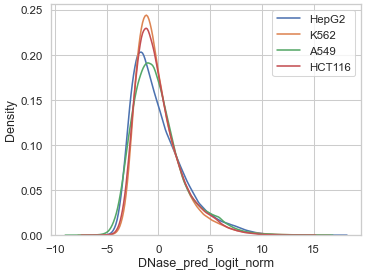

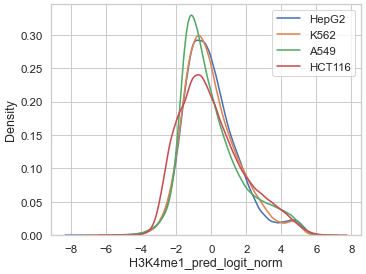

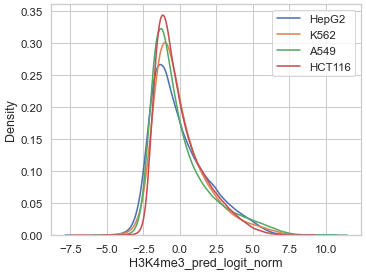

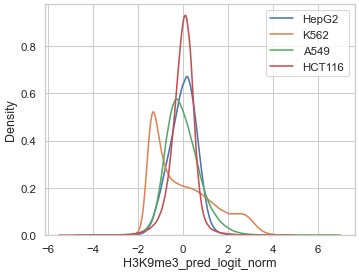

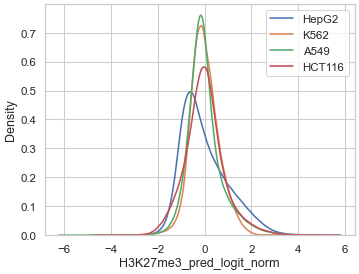

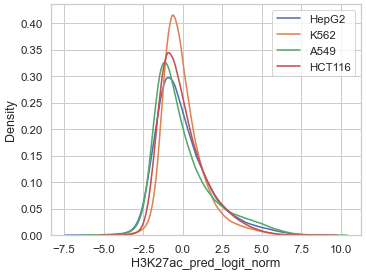

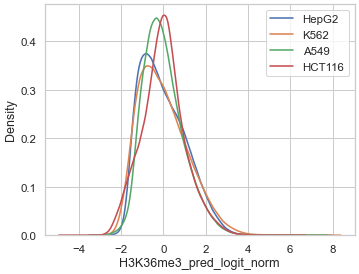

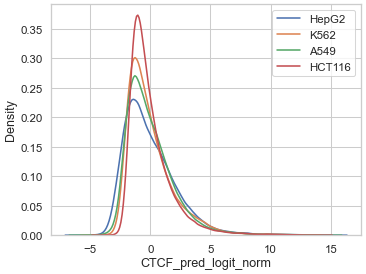

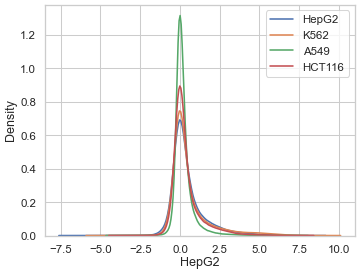

In [8]:
for assay in assays:
    plt.figure(figsize=(8, 6), dpi=50)
    for cell_type in cell_types:
        x = main_df[f'{cell_type}_{assay}_pred_logit_norm']
        sns.kdeplot(x, label=cell_type)
        plt.xlabel(f'{assay}_pred_logit_norm')
    plt.legend()


plt.figure(figsize=(8, 6), dpi=50)
for cell_type in cell_types:
        y = main_df[cell_type]
        sns.kdeplot(y, label=cell_type)
plt.legend()

In [8]:

cell_types = ['HepG2', 'K562', 'A549', 'HCT116']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'CTCF']
data_splits = ['total', 'train', 'valid', 'test', 'designed', 'const', 'diff']

r_matrix = np.zeros((len(cell_types), len(data_splits)))
r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits)

for cell_type in cell_types:
    # train
    data_split = 'train'
    print(f'train model by {cell_type} {data_split} data')
    condition = data_split_dict[data_split]
    df = main_df[condition]
    selected_columns = [f'{cell_type}_{assay}_pred_logit_norm' for assay in assays]
    X_train = np.array(df[selected_columns])
    y_train = np.array(df[f'{cell_type}'])

    X_train, y_train = remove_nan(X_train, y_train)
    if len(X_train) == 0:
        continue
    
    model = LinearRegression()
    # model = Lasso(alpha=1e-3)
    # model = MLPRegressor(hidden_layer_sizes=10, alpha=1e-3)
    model.fit(X_train, y_train)

    # valid
    for cell_type in cell_types:
        for data_split in data_splits:
            condition = data_split_dict[data_split]
            df = main_df[condition]
            selected_columns = [f'{cell_type}_{assay}_pred_logit_norm' for assay in assays]
            X_valid = np.array(df[selected_columns])
            y_valid = np.array(df[f'{cell_type}'])

            X_valid, y_valid = remove_nan(X_valid, y_valid)
            if len(X_valid) == 0:
                continue
            y_pred = model.predict(X_valid)
            r = pearson(y_valid, y_pred)
            r_matrix[data_split][cell_type] = r

            # print(f"{cell_type} {data_split} Pearson's r: {r:.3f}")
    print(r_matrix)
    print()

train model by HepG2 designed data
           total     train     valid      test  designed     const      diff
HepG2   0.550120  0.577920  0.566168  0.551653  0.449539  0.417773  0.536193
K562    0.611805  0.561862  0.550316  0.531695  0.699122  0.362164  0.610134
A549    0.444034  0.446064  0.447167  0.419561  0.000000  0.275480  0.508098
HCT116  0.359705  0.361386  0.358108  0.348698  0.000000  0.205348  0.483713

train model by K562 diff data
           total     train     valid      test  designed     const      diff
HepG2   0.573985  0.521334  0.510593  0.500246  0.682090  0.370178  0.586919
K562    0.680292  0.619458  0.607765  0.589168  0.760811  0.447749  0.669582
A549    0.419318  0.421658  0.419498  0.396362  0.000000  0.240684  0.466409
HCT116  0.427267  0.428458  0.430874  0.414000  0.000000  0.272929  0.509042

train model by A549 diff data
           total     train     valid      test  designed     const      diff
HepG2   0.582950  0.549316  0.541272  0.529716  0.645029

In [9]:
# leave-one-out cross-validation
# input norm

cell_types = ['HepG2', 'K562', 'A549', 'HCT116']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'CTCF']
data_splits = ['total', 'train', 'valid', 'test', 'designed', 'const', 'diff']


valid_r_matrix = np.zeros((len(cell_types), len(data_splits)))
valid_r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits)


for selected_cell_type in cell_types:
    r_matrix = np.zeros((len(cell_types), len(data_splits)))
    r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits)

    # train
    data_split = 'train'
    print(f'train model by not {selected_cell_type} data')

    X_train = []
    y_train = []
    for train_cell_type in cell_types:
        if train_cell_type == selected_cell_type:
            continue
        condition = data_split_dict[data_split]
        df = main_df[condition]

        X_columns = [f'{train_cell_type}_{assay}_pred_logit_norm' for assay in assays]
        y_column = train_cell_type
        X_train.append(df[X_columns])
        y_train.append(df[y_column])

    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    X_train, y_train = remove_nan(X_train, y_train)
    if len(X_train) == 0:
        continue

    model = LinearRegression()
    # model = Lasso(alpha=1e-3)
    # model = MLPRegressor(hidden_layer_sizes=10, alpha=1e-3)
    model.fit(X_train, y_train)

    # valid
    for valid_cell_type in cell_types:

        X_columns = [f'{valid_cell_type}_{assay}_pred_logit_norm' for assay in assays]
        y_column = valid_cell_type
        X = np.array(main_df[X_columns])
        y = np.array(main_df[y_column])
        # X, y = remove_nan(X, y)
        y_pred = model.predict(X)
        
        main_df[f'{valid_cell_type}_pred_by_leave_one_out_model'] = y_pred
    
        for data_split in data_splits:
            condition = data_split_dict[data_split]
            df = main_df[condition]
            y_column = valid_cell_type
            y_valid = np.array(df[y_column])
            y_pred = np.array(df[f'{valid_cell_type}_pred_by_leave_one_out_model'])

            r = pearson(y_valid, y_pred)
            r_matrix[data_split][valid_cell_type] = r
            if valid_cell_type == selected_cell_type:
                valid_r_matrix[data_split][selected_cell_type] = r
    print(r_matrix)
    print()

print('leave one out validation')
print(valid_r_matrix)

train model by not HepG2 data
           total     train     valid      test  designed     const      diff
HepG2   0.574226  0.552164  0.540733  0.529251  0.639471  0.393049  0.565736
K562    0.661686  0.599485  0.586922  0.568910  0.750757  0.418934  0.649365
A549    0.433399  0.435846  0.434919  0.407356       NaN  0.259033  0.488401
HCT116  0.477435  0.478721  0.481418  0.462044       NaN  0.317111  0.574081

train model by not K562 data
           total     train     valid      test  designed     const      diff
HepG2   0.566014  0.563250  0.553925  0.542969  0.580853  0.414414  0.539994
K562    0.631579  0.546215  0.533378  0.516598  0.749689  0.371241  0.632651
A549    0.442943  0.445261  0.444896  0.417078       NaN  0.277843  0.492370
HCT116  0.471092  0.472052  0.475197  0.459930       NaN  0.313898  0.574525

train model by not A549 data
           total     train     valid      test  designed     const      diff
HepG2   0.575993  0.559751  0.548051  0.536204  0.626160  0.399

In [34]:
# leave-one-out cross-validation
# input norm

cell_types = ['HepG2', 'K562', 'A549', 'HCT116']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K36me3', 'CTCF']
data_splits = ['train', 'valid', 'test', 'designed']
# leave-one-out cross-validation
# input norm


valid_r_matrix = np.zeros((len(cell_types), len(data_splits)))
valid_r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits)


for cell_type in cell_types:
    r_matrix = np.zeros((len(cell_types), len(data_splits)))
    r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits)

    # train
    data_split = 'train'
    print(f'train model by not {cell_type} data')

    X_train = []
    y_train = []
    for train_cell_type in cell_types:
        if train_cell_type == cell_type:
            continue
        condition = data_split_dict[data_split]
        df = main_df[condition]

        X_columns = [f'{train_cell_type}_{assay}_pred_logit_norm' for assay in assays]
        y_column = train_cell_type
        X_train.append(df[X_columns])
        y_train.append(df[y_column])

    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    X_train, y_train = remove_nan(X_train, y_train)
    if len(X_train) == 0:
        continue

    model = LinearRegression()
    # model = Lasso(alpha=1e-3)
    # model = MLPRegressor(hidden_layer_sizes=10, alpha=1e-3)
    model.fit(X_train, y_train)

    # valid
    for valid_cell_type in cell_types:
        for data_split in data_splits:
            condition = data_split_dict[data_split]
            df = main_df[condition]

            X_columns = [f'{valid_cell_type}_{assay}_pred_logit_norm' for assay in assays]
            y_column = valid_cell_type
            X_valid = np.array(df[X_columns])
            y_valid = np.array(df[y_column])

            X_valid, y_valid = remove_nan(X_valid, y_valid)
            if len(X_valid) == 0:
                continue
            y_pred = model.predict(X_valid)
            r = pearson(y_valid, y_pred)
            
            r_matrix[data_split][valid_cell_type] = r
            # print(f"{valid_cell_type} {data_split} Pearson's r: {r:.3f}")
            if valid_cell_type == cell_type:
                valid_r_matrix[data_split][cell_type] = r
    print(r_matrix)
    print()

print('leave one out validation')
print(valid_r_matrix)

train model by not HepG2 data
warning, 0 of 76168 values are non-nan.
warning, 0 of 76168 values are non-nan.
           train     valid      test  designed
HepG2   0.523273  0.513847  0.503616  0.594460
K562    0.575221  0.562663  0.541127  0.748951
A549    0.391589  0.390131  0.364472  0.000000
HCT116  0.468485  0.470843  0.451540  0.000000

train model by not K562 data
warning, 0 of 76168 values are non-nan.
warning, 0 of 76168 values are non-nan.
           train     valid      test  designed
HepG2   0.523809  0.514384  0.504642  0.584330
K562    0.554881  0.542217  0.522194  0.742232
A549    0.395056  0.395758  0.370235  0.000000
HCT116  0.481427  0.482752  0.467539  0.000000

train model by not A549 data
warning, 0 of 76168 values are non-nan.
warning, 0 of 76168 values are non-nan.
           train     valid      test  designed
HepG2   0.526925  0.516808  0.505628  0.562769
K562    0.574125  0.561294  0.539256  0.739839
A549    0.378375  0.374187  0.348693  0.000000
HCT116  0.46